In [1]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
from sklearn.impute import SimpleImputer
import seaborn as sb

In [2]:
cov19 = pd.read_csv("Data.csv")
cov19 = cov19.rename(columns={'Entity': 'Country', 'Latitude': 'Lat' , 'Longitude': 'Long',\
                              'Average temperature per year': 'Avg Temp per year', \
                              'Hospital beds per 1000 people': 'Beds per thousand', \
                              'Medical doctors per 1000 people': 'Doctors per thousand', \
                              'Population aged 65 and over (%)' : 'Percent Population Age over 65', \
                              'GDP/Capita': 'GDP per Capita'}) #Shorten column names

In [3]:
cov19.isna().sum().sum() #Number of NAs

11759

In [4]:
#Impute NA values
imputer = SimpleImputer(missing_values=np.NaN, strategy='mean')
cov19_1 = imputer.fit_transform([cov19['Daily tests'], cov19['Cases'], cov19['Deaths']])
cov19_1 = pd.DataFrame(np.transpose(cov19_1), columns = ['Daily tests','Cases','Deaths'])
cov19[['Daily tests','Cases','Deaths']]=cov19_1 

In [5]:
cov19.shape

(38472, 15)

In [6]:
cov19.head()

,Country,Continent,Lat,Long,Avg Temp per year,Beds per thousand,Doctors per thousand,GDP per Capita,Population,Median age,Percent Population Age over 65,Date,Daily tests,Cases,Deaths
0,Albania,Europe,41.15,20.17,14,2.89,1.29,5353.2,2873457,38,14,2020-02-25,8.0,8.0,8.0
1,Albania,Europe,41.15,20.17,14,2.89,1.29,5353.2,2873457,38,14,2020-02-26,5.0,5.0,5.0
2,Albania,Europe,41.15,20.17,14,2.89,1.29,5353.2,2873457,38,14,2020-02-27,4.0,4.0,4.0
3,Albania,Europe,41.15,20.17,14,2.89,1.29,5353.2,2873457,38,14,2020-02-28,1.0,1.0,1.0
4,Albania,Europe,41.15,20.17,14,2.89,1.29,5353.2,2873457,38,14,2020-02-29,8.0,8.0,8.0


In [7]:
con = sqlite3.connect("cov19.db")
cur=con.cursor()

In [9]:
cur.execute('''CREATE TABLE Continents( \
    Id INT, \
    Continent CHAR UNIQUE, \
    PRIMARY KEY (Id))''')
cur.execute('''CREATE TABLE Countries( \
    Id INT, \
    Country CHAR UNIQUE,\
    Cont_Id INT, \
    Lat FLOAT(24), \
    Long FLOAT(24), \
    "Avg Temp per year" INT, \
    "Beds per thousand" FLOAT(24), \
    "Doctors per thousand" FLOAT(24), \
    "GDP per Capita" FLOAT(24), \
    Population INT, \
    "Median Age" INT, \
    "Percent Population Age over 65" INT, \
    PRIMARY KEY (Country), \
    FOREIGN KEY (Cont_Id) REFERENCES Continents(Id))''')
cur.execute('''CREATE TABLE Cases( \
    Id INT, \
    Country CHAR, \
    Date, \
    "Daily tests" FLOAT(24),\
    Cases FLOAT(24),\
    Deaths FLOAT(24),\
    PRIMARY KEY (Id),\
    FOREIGN KEY (Country) REFERENCES Countries(Country))''')

In the following, I would create the Continents table, which would contain the Continents that are in the cov19 dataframe.

In [10]:
df_cont = pd.DataFrame(cov19["Continent"].unique(), columns=["Continent"])
df_cont['Id']=pd.factorize(df_cont['Continent'])[0]
df_cont=df_cont[['Id','Continent']]

In [11]:
df_cont.to_sql("Continents", con, if_exists="append", index=False)
con.commit()

In the following, I would create the Countries table, which would include the demographics of each country.

In [12]:
cov19['Country'].nunique()

104

In [13]:
df_country = cov19.drop(columns=['Date','Daily tests','Cases','Deaths']).drop_duplicates()
df_country['Cont_Id']=pd.factorize(df_country['Continent'])[0]
df_country['Id']=pd.factorize(df_country['Country'])[0]
df_country=df_country[['Id','Country','Cont_Id','Lat','Long','Avg Temp per year',\
                      'Beds per thousand','Doctors per thousand','GDP per Capita','Population','Median age',\
                      'Percent Population Age over 65']]

In [14]:
df_country.to_sql("Countries", con, if_exists="append", index=False)
con.commit

C:\Users\user\ansel\lib\site-packages\pandas\core\generic.py:2789: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  method=method,


<function Connection.commit>

In the following, I would create the Cases table, which would include the Daily tests, Cases and Deaths for each day, for each country.

In [15]:
df_cases = cov19[['Country','Date','Daily tests','Cases','Deaths']]
df_cases['Id']=list(range(0,len(df_cases)))
df_cases = df_cases[['Id','Country','Date','Daily tests','Cases','Deaths']]

C:\Users\user\ansel\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [16]:
df_cases.to_sql("Cases", con, if_exists="append", index=False)
con.commit

<function Connection.commit>

In [17]:
pd.read_sql_query('SELECT * FROM Cases',con)

,Id,Country,Date,Daily tests,Cases,Deaths
0,0,Albania,2020-02-25,8.0,8.0,8.0
1,1,Albania,2020-02-26,5.0,5.0,5.0
2,2,Albania,2020-02-27,4.0,4.0,4.0
3,3,Albania,2020-02-28,1.0,1.0,1.0
4,4,Albania,2020-02-29,8.0,8.0,8.0
...,...,...,...,...,...,...
38467,38467,Zimbabwe,2021-02-24,1804.0,35960.0,1456.0
38468,38468,Zimbabwe,2021-02-25,2965.0,35994.0,1458.0
38469,38469,Zimbabwe,2021-02-26,18753.5,36044.0,1463.0
38470,38470,Zimbabwe,2021-02-27,18760.5,36058.0,1463.0


For the data visualisation, I attempt to investigate the factors that are significant in affecting the covid-19 cases in countries. I start off by finding the correlation matrix of covid-19 cases with the respective variables.

In [18]:
plt.rcParams['figure.figsize'] = [20, 10]

<AxesSubplot:>

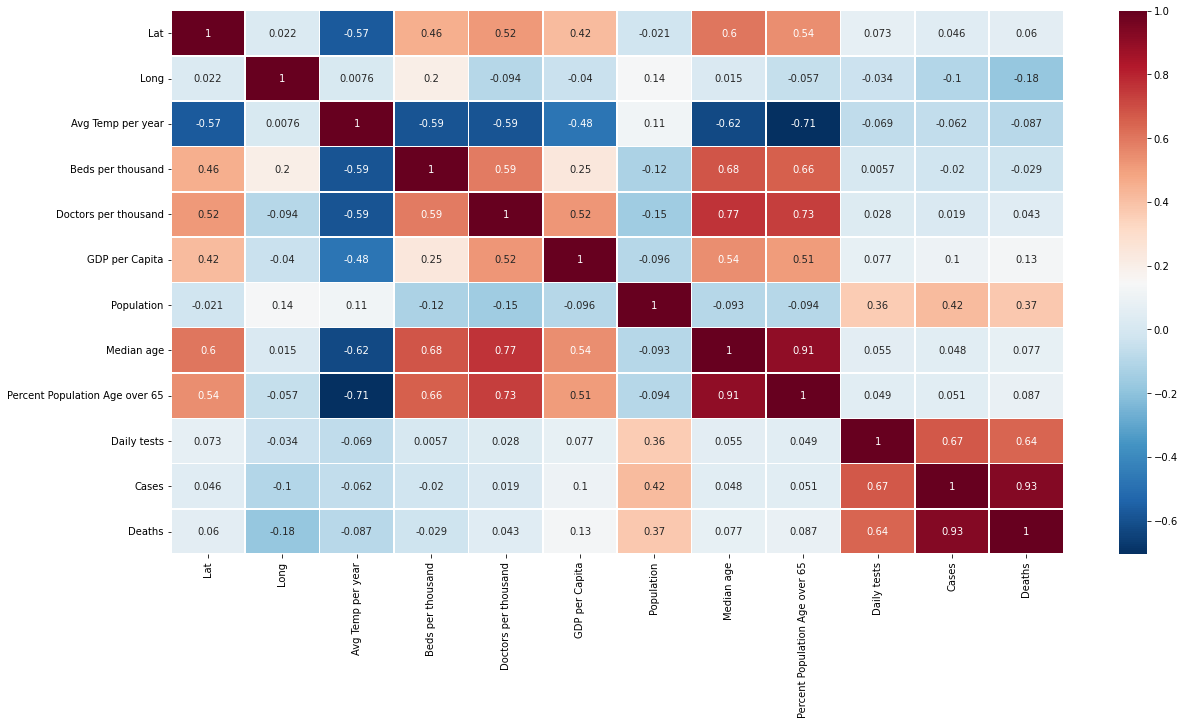

In [19]:
pearcorr = cov19.corr(method='pearson')
sb.heatmap(pearcorr, 
          xticklabels=pearcorr.columns,
          yticklabels=pearcorr.columns,
          cmap='RdBu_r',
          annot=True,
          linewidth=0.5)

It can be seen that covid-19 cases has the highest correlation with deaths, daily tests, and country's population. The following plot would show the plot of each country's population, and the number of cases of each country. The covid-19 case number is taken from the last date entry in the dataset (i.e. the latest available date).
 

In [20]:
a = pd.read_sql_query('''SELECT Country, Cases FROM Cases 
    WHERE 
    Date IN (SELECT MAX(Date) FROM Cases)''', con) #Select cases on last date entry for each country
b = pd.read_sql_query(''' SELECT Country, Population FROM Countries''',con)
a_b = pd.merge(b,a, on='Country', how='outer')
a_b

,Country,Population,Cases
0,Albania,2873457,107167.0
1,Algeria,41318142,113092.0
2,Argentina,44271041,2107365.0
3,Armenia,2930450,172058.0
4,Australia,24598933,28978.0
...,...,...,...
99,United States,325719178,28605669.0
100,Uruguay,3456750,57994.0
101,Vietnam,95540800,2448.0
102,Zambia,17094130,78534.0


<AxesSubplot:label='b220c239-79af-43cc-ab5d-5c82be4ffdd1'>

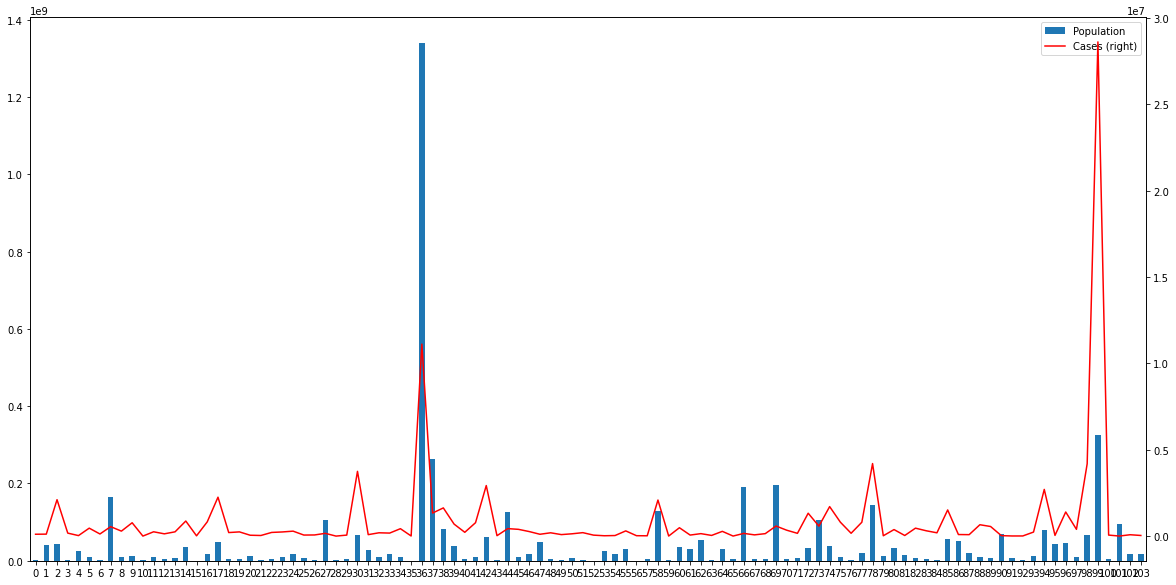

In [21]:
a_b[['Country','Population']].plot(kind='bar')
a_b['Cases'].plot(color='red', secondary_y=True, legend=True)

From the plot, it can be seen that there are some obvious points where a higher population indeed corresponds to high covid-19 case number, with the exception of two points.

From the correlation matrix, GDP per Capita has an unusually low correlation with covid-19 cases. To visualise this relationship, I select only 3 countries with the highest GDP/Capita, and 3 countries with the lowest GDP/Capita. For the 6 selected countries, the proportion of deaths against covid-19 cases is also obtained and plotted as well.

In [37]:
#Bottom 3 GDP/Capita countries
bot_GDP = pd.read_sql_query(''' SELECT * FROM Cases 
    WHERE Country IN (
    SELECT Country FROM Countries ORDER BY "GDP per Capita" ASC LIMIT 3)''',con)

#Top 3 GDP/Capita countries
top_GDP = pd.read_sql_query(''' SELECT * FROM Cases 
    WHERE Country IN (
    SELECT Country FROM Countries ORDER BY "GDP per Capita" DESC LIMIT 3)''',con) 

In [38]:
#Proportion of deaths against cases
bot_GDP['Prop']=bot_GDP.apply(lambda row: row.Deaths/row.Cases, axis=1)
top_GDP['Prop']=top_GDP.apply(lambda row: row.Deaths/row.Cases, axis=1)

Text(0.5, 1.0, 'Plots of proportion of deaths against cases')

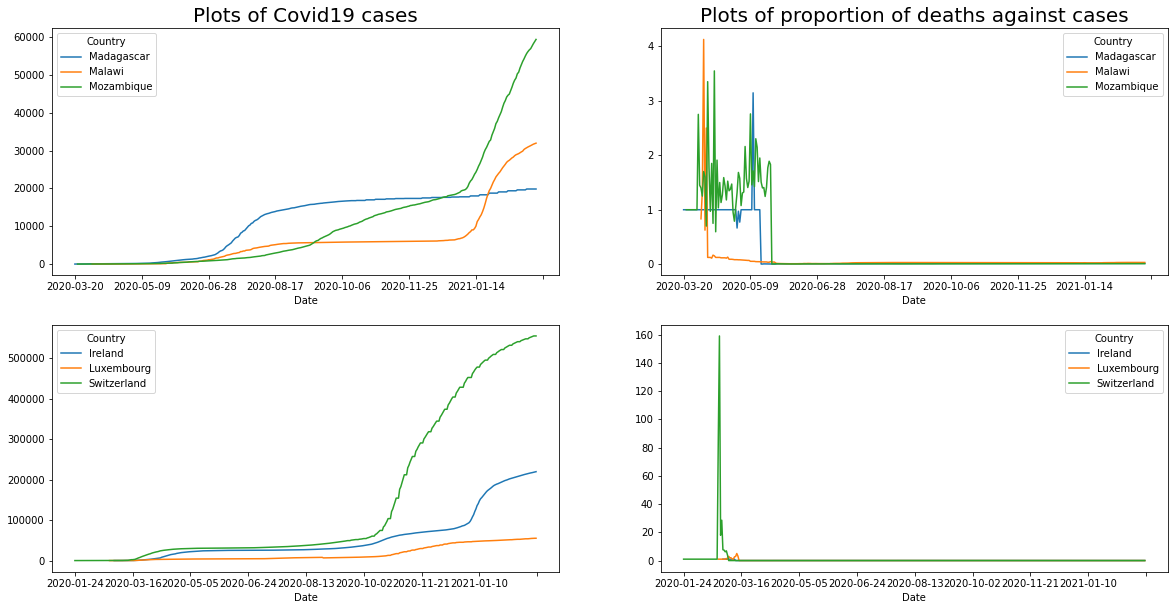

In [39]:
fig, axes = plt.subplots(nrows=2, ncols=2)
bot_GDP.pivot(index='Date', columns='Country', values='Cases').plot(ax=axes[0,0])
top_GDP.pivot(index='Date', columns='Country', values='Cases').plot(ax=axes[1,0])
bot_GDP.pivot(index='Date', columns='Country', values='Prop').plot(ax=axes[0,1])
top_GDP.pivot(index='Date', columns='Country', values='Prop').plot(ax=axes[1,1])
axes[0,0].set_title("Plots of Covid19 cases", fontsize=20)
axes[0,1].set_title("Plots of proportion of deaths against cases", fontsize=20)

From this visualisation, it can be seen that the spread of covid-19 is indeed independent of GDP/Capita, where cases initially increase slightly, stayed relatively constant for a while before increasing sharply.
The plots for the proportion of deaths is also the same, where it eventually goes close to zero for both groups. This could possibly be due to the increasing amount of cases in both groups, and the decrease in lethality of the virus through virus mutations.
The above is supported by the plot below, where the number of cases of each country is taken from the last date entry in the dataset (i.e. the latest date). This case number is then plotted against GDP/Capita, and colour-coded according to the Continent that the Country is in. It shows that cases generally do not defer too much, regardless of GDP/Capita.

In [22]:
c = pd.read_sql_query('''SELECT Countries.Country, Continents.Continent, Countries."GDP per Capita" 
    FROM Countries
    LEFT JOIN Continents ON Continents.Id=Countries.Cont_Id
    ''', con)
a_c = pd.merge(c,a, on='Country', how='outer')

Text(0, 0.5, 'Cases')

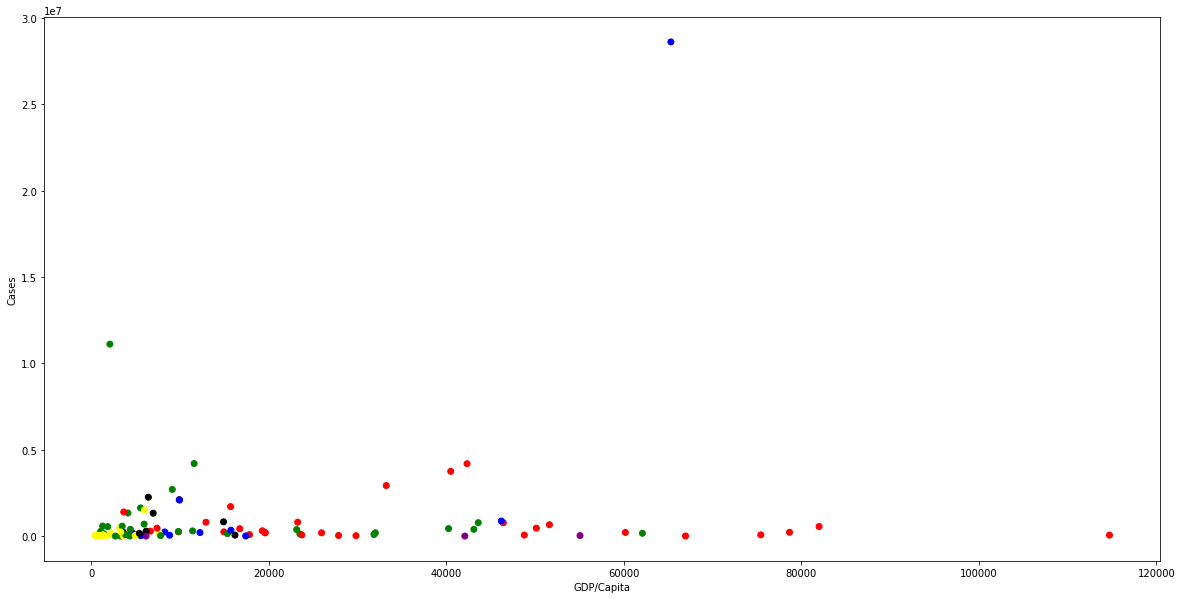

In [23]:
colors = {'Europe':'red', 'Africa':'yellow', 'South America':'black', 'Oceania':'purple', 'Asia':'green', 'North America':'blue'}
plt.scatter(a_c['GDP per Capita'], a_c['Cases'], c=[colors[i] for i in a_c['Continent']])
plt.xlabel('GDP/Capita')
plt.ylabel('Cases')

Lastly, I aim to observe whether a country's covid-19 policy affects the spread of covid-19 in the country. To achieve this, I choose to investigate covid-19 cases between the United States, United Kingdom, Israel, and New Zealand.

<AxesSubplot:xlabel='Date'>

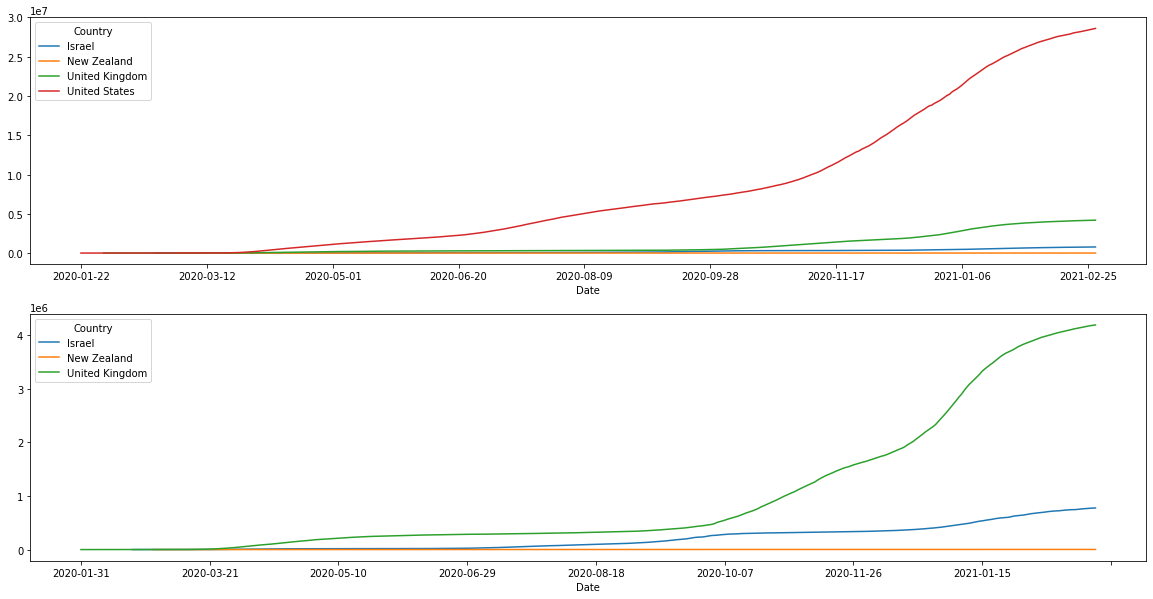

In [28]:
fig, axes_2 = plt.subplots(nrows=2, ncols=1)
sel1 = pd.read_sql_query(''' SELECT * FROM Cases WHERE Country IN ('United States','United Kingdom',
    'New Zealand','Israel')''',con)
sel2 = pd.read_sql_query(''' SELECT * FROM Cases WHERE Country IN ('United Kingdom','New Zealand','Israel')''',con)

sel1.pivot(index='Date', columns='Country', values='Cases').plot(ax=axes_2[0])
sel2.pivot(index='Date', columns='Country', values='Cases').plot(ax=axes_2[1])

United States and the United Kingdoms were 2 countries with a relative laxed policy when it comes to tackling Covid19, whereas New Zealand and Israel were quick to respond to the covid-19 threat. In fact, New Zealand has been praised as having one of the best responses to covid-19. From the plots, it can be seen that both the US and UK has a significantly higher case number. The second plot was plotted without the US, because the US has a disproportionately high number of covid-19 cases.
It can be seen that covid-19 response and policy of a country do matter when it comes to controlling the pandemic.